# Setting up

In [ ]:
# Basic imports
import pandas as pd                 # data handling
import numpy as np                  # numeric ops
import matplotlib.pyplot as plt     # plotting
import seaborn as sns               # nicer plots

# Statistical tests / modeling
from scipy import stats              # t-test
import statsmodels.api as sm         # ANOVA (ols)
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Load cleaned CSV export from SQL
df = pd.read_csv("united_reviews.csv")
# Ensure RECOMMENDED is boolean and cabin class split available
df['RECOMMENDED'] = df['RECOMMENDED'].astype(int)
df['CABIN_GROUP'] = df['SEAT_TYPE'].apply(lambda s: 'Economy' if 'Economy' in str(s) else 'Non-Economy')

# Exploratory Data Analysis

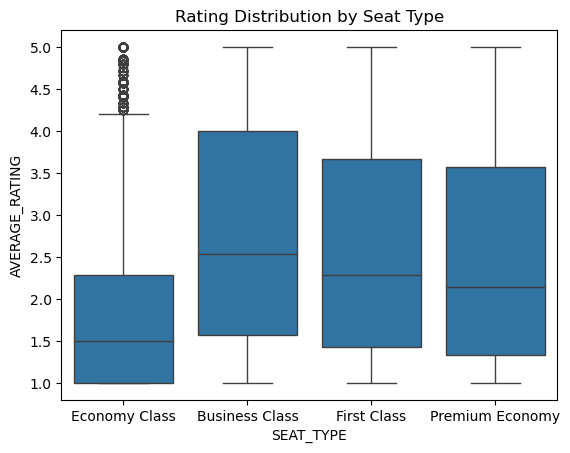

In [8]:
# Create a boxplot to visualize distribution of ratings by seat type
sns.boxplot(x="SEAT_TYPE", y="AVERAGE_RATING", data=df)

# Add a title for clarity
plt.title("Rating Distribution by Seat Type")

# Show the plot
plt.show()

# Quick distribution checks for key metrics

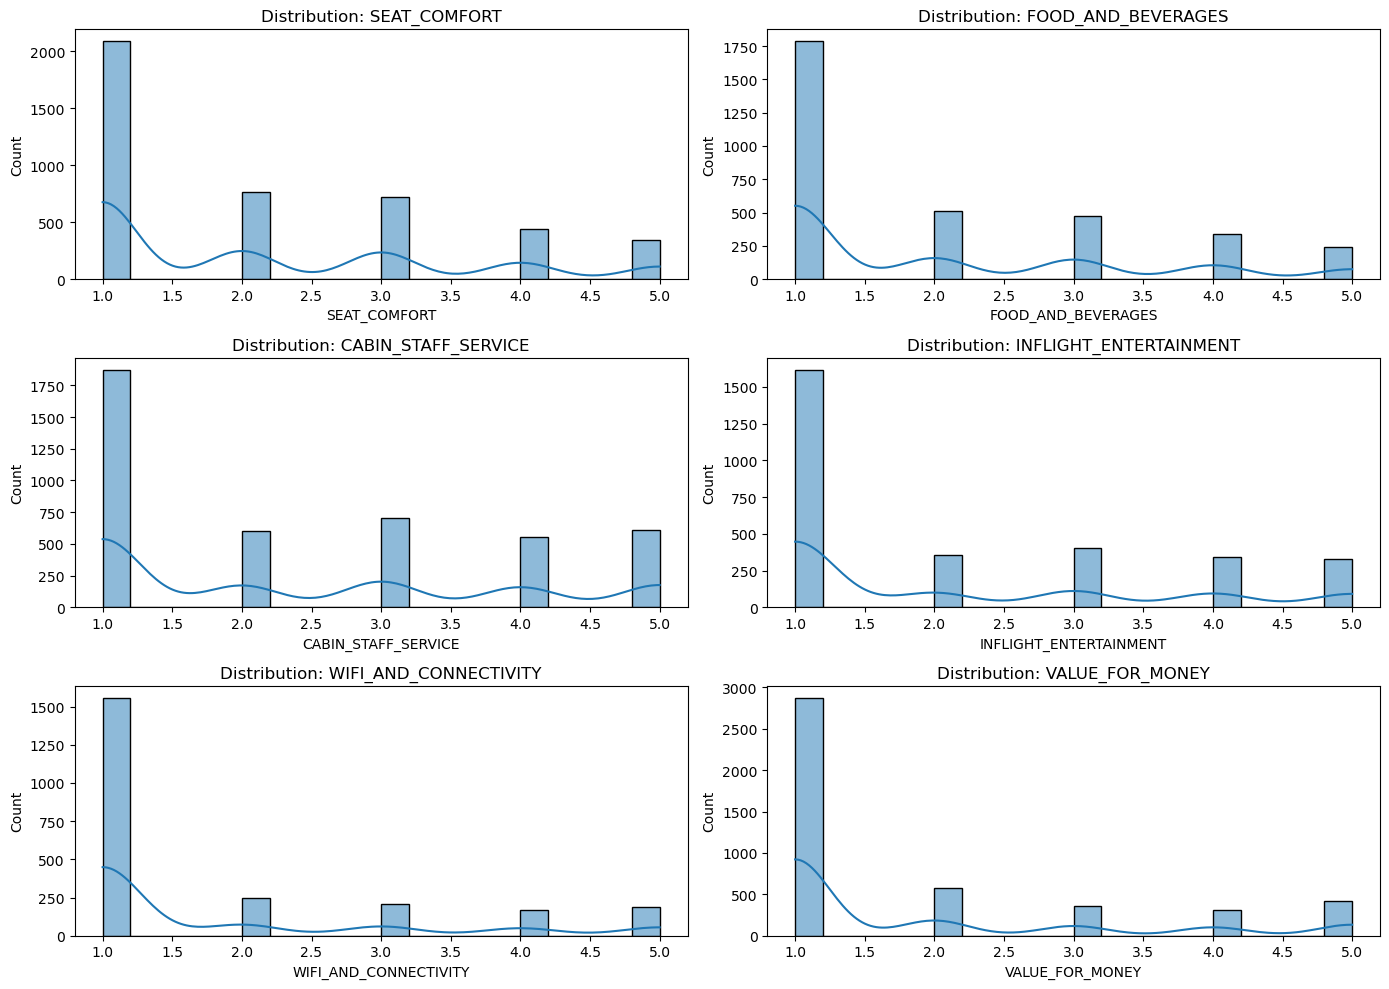

In [7]:
# Plot histograms for key metrics to inspect distributions
metrics = ['SEAT_COMFORT', 'FOOD_AND_BEVERAGES', 'CABIN_STAFF_SERVICE',
           'INFLIGHT_ENTERTAINMENT', 'WIFI_AND_CONNECTIVITY', 'VALUE_FOR_MONEY']

plt.figure(figsize=(14, 10))
for i, m in enumerate(metrics, 1):
    plt.subplot(3, 2, i)                                # 3x2 grid
    sns.histplot(df[m].dropna(), kde=True, bins=20)     # histogram + KDE
    plt.title(f'Distribution: {m}')
plt.tight_layout()
plt.show()


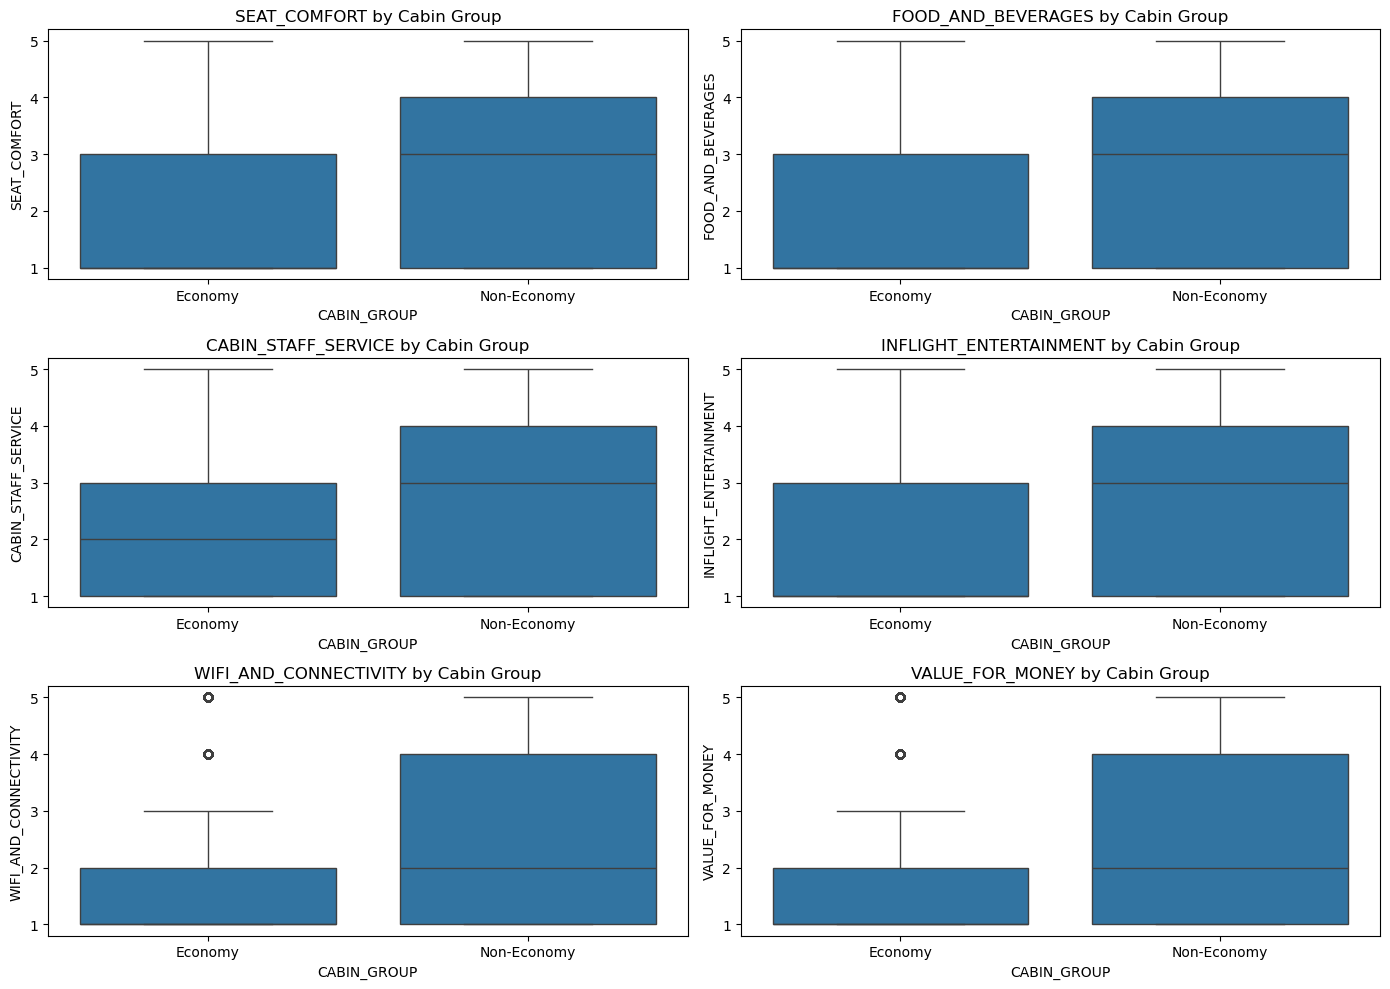

In [9]:
# Boxplots to compare Economy vs Non-Economy distribution for each metric
plt.figure(figsize=(14, 10))
for i, m in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='CABIN_GROUP', y=m, data=df)
    plt.title(f'{m} by Cabin Group')
plt.tight_layout()
plt.show()

# Two-sample t-test: Economy vs Non-Economy

In [3]:
# Function for independent t-test (Welch's t-test — does not assume equal variance)
def ttest_econ_vs_non(df, metric):
    econ = df.loc[df['CABIN_GROUP']=='Economy', metric].dropna()
    non = df.loc[df['CABIN_GROUP']=='Non-Economy', metric].dropna()
    tstat, pvalue = stats.ttest_ind(econ, non, equal_var=False)  # Welch's t-test
    return tstat, pvalue, len(econ), len(non)

# Run tests for all metrics and display
results = []
for m in metrics:
    t, p, n_e, n_ne = ttest_econ_vs_non(df, m)
    results.append({'metric': m, 't_stat': t, 'p_value': p, 'n_econ': n_e, 'n_non': n_ne})

pd.DataFrame(results)


,metric,t_stat,p_value,n_econ,n_non
0,SEAT_COMFORT,-14.575802,5.281659e-42,3803,554
1,FOOD_AND_BEVERAGES,-9.828914,2.229908e-21,2831,516
2,CABIN_STAFF_SERVICE,-9.744839,3.925401e-21,3790,554
3,INFLIGHT_ENTERTAINMENT,-9.963109,9.836586e-22,2593,459
4,WIFI_AND_CONNECTIVITY,-6.592666,1.755903e-10,2103,274
5,VALUE_FOR_MONEY,-10.507213,5.209309e-24,3977,565


# ANOVA

In [10]:
# Compare multiple seat categories
# Example for SEAT_COMFORT
model = smf.ols('SEAT_COMFORT ~ C(SEAT_TYPE)', data=df).fit()  # OLS with categorical seat type
anova_table = sm.stats.anova_lm(model, typ=2)                 # ANOVA table
print(anova_table)


                   sum_sq      df           F        PR(>F)
C(SEAT_TYPE)   548.398170     3.0  113.208332  1.382293e-70
Residual      7025.632599  4351.0         NaN           NaN


# Predict RECOMMENDED from metrics

In [5]:
# Select predictors and drop rows with NaNs in these columns
predictors = ['SEAT_COMFORT', 'FOOD_AND_BEVERAGES', 'CABIN_STAFF_SERVICE', 'WIFI_AND_CONNECTIVITY', 'VALUE_FOR_MONEY']
model_df = df[predictors + ['RECOMMENDED']].dropna()

X = model_df[predictors]
y = model_df['RECOMMENDED']

# Train/test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit logistic regression (default L2 penalty). Increase max_iter if it warns.
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)

# Predictions & evaluation
y_pred = logit.predict(X_test)
y_proba = logit.predict_proba(X_test)[:, 1]  # probability of class 1

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Feature importance (coefficients)
coef_df = pd.DataFrame({
    'feature': predictors,
    'coefficient': logit.coef_[0]
}).sort_values(by='coefficient', ascending=False)
print(coef_df)


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       546
           1       0.89      0.92      0.91       117

    accuracy                           0.97       663
   macro avg       0.94      0.95      0.94       663
weighted avg       0.97      0.97      0.97       663

ROC AUC: 0.9888309696002002
                 feature  coefficient
4        VALUE_FOR_MONEY     1.519573
2    CABIN_STAFF_SERVICE     0.759375
1     FOOD_AND_BEVERAGES     0.434013
0           SEAT_COMFORT     0.366424
3  WIFI_AND_CONNECTIVITY     0.102011
